In [60]:
import warnings

warnings.filterwarnings("ignore")

import pyscenic
import loompy as lp
import scanpy as sc
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
import glob
import json
import zlib
import base64
import anndata as ad

# Data load and preparation

In [124]:
adata = sc.read_h5ad("1_qc.h5ad")
adata.shape

(10876, 29965)

In [125]:
adata.var["feature_types"].unique()

['Gene Expression']
Categories (1, object): ['Gene Expression']

In [126]:
tfs_path = "../data/reference/mouse/allTFs_mm.txt"
loom_path = "../data/scenic/data_processed_input.loom"
loom_path_output = "../data/scenic/data_processed_output.loom"
outpath_adj = "../data/scenic/adj.csv"
motif_path = "../data/reference/mouse/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl"
reg_path = "../data/scenic/reg.csv"
db_glob = "../data/reference/mouse/*feather"
db_names = " ".join(glob.glob(db_glob))

In [127]:
tfs = [tf.strip() for tf in open(tfs_path)]
tfs

['1700009N14Rik',
 '1700080O16Rik',
 '1810024B03Rik',
 '2010315B03Rik',
 '2310011J03Rik',
 '2410141K09Rik',
 '2610044O15Rik8',
 '2810403A07Rik',
 '3300002I08Rik',
 '3830417A13Rik',
 '4921501E09Rik',
 '4921509C19Rik',
 '5730507C01Rik',
 '6720489N17Rik',
 '9030624G23Rik',
 '9130019O22Rik',
 '9130023H24Rik',
 'A1cf',
 'Abcf2',
 'Abl1',
 'Acaa1a',
 'Acaa1b',
 'Aco1',
 'Adarb1',
 'Adnp',
 'Adnp2',
 'Aebp2',
 'Aff4',
 'Agap2',
 'Aggf1',
 'Agmat',
 'Ahctf1',
 'Ahr',
 'Ahrr',
 'AI987944',
 'Aire',
 'Ak6',
 'Akr1a1',
 'Alx1',
 'Alx3',
 'Alx4',
 'Anxa1',
 'Anxa11',
 'Apex1',
 'Apex2',
 'Ar',
 'Arfgap1',
 'Arg1',
 'Arg2',
 'Arid3a',
 'Arid3b',
 'Arid3c',
 'Arid5a',
 'Arid5b',
 'Arnt',
 'Arnt2',
 'Arntl',
 'Arntl2',
 'Arx',
 'Asap3',
 'Ascc1',
 'Ascl1',
 'Ascl2',
 'Ash2l',
 'Aspscr1',
 'Atf1',
 'Atf2',
 'Atf3',
 'Atf4',
 'Atf5',
 'Atf6',
 'Atf6b',
 'Atf7',
 'Atoh1',
 'Atoh7',
 'Atoh8',
 'AU041133',
 'Aven',
 'AW146154',
 'AW822073',
 'B230307C23Rik',
 'Bach1',
 'Bach2',
 'Bad',
 'Banp',
 'Barhl1',

In [128]:
adata = adata[adata.obs['sample_type'] == 'combined', :]
adata

View of AnnData object with n_obs × n_vars = 2488 × 29965
    obs: 'sample', 'sample_type', 'barcode', 'well_position', 'well_row', 'well_column', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'total_counts_lncRNA', 'log1p_total_counts_lncRNA', 'pct_counts_lncRNA', 'n_genes', 'doublet_score', 'predicted_doublet', 'sample_group', 'facs_day'
    var: 'gene_ids', 'feature_types', 'gene_symbol', 'gene_versions', 'gene_type', 'mt', 'rRNA', 'lncRNA', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'scrublet'
    layers: 'ambiguous', 'count', 'log1p', 'spliced', 'unspliced'

In [129]:
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)
#adata = adata[:, adata.var.highly_variable]    # do not do this step to keep the entire expression matrix?
#sc.pp.regress_out(adata, keys=['total_counts', 'pct_counts_mt','pct_counts_rpl','pct_counts_rps'], n_jobs=16)
#sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.external.pp.harmony_integrate(adata, "sample", max_iter_harmony=50)
sc.pp.neighbors(adata, use_rep="X_pca_harmony")
sc.tl.umap(adata)
sc.tl.pca(adata, svd_solver='arpack')
adata.obsm["X_umap_harmony"] = adata.obsm["X_umap"].copy()
adata.obsm['X_pca_harmony']=adata.obsm['X_pca'].copy()
sc.tl.leiden(adata, resolution=0.5)

#!pyscenic grn {f_loom_path_scenic} {Mouse_TFS_FNAME} -o {ADJACENCIES_FNAME} --num_workers 16

2025-03-12 11:02:51,608 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-12 11:02:52,489 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-12 11:02:52,502 - harmonypy - INFO - Iteration 1 of 50
2025-03-12 11:02:52,884 - harmonypy - INFO - Iteration 2 of 50
2025-03-12 11:02:53,271 - harmonypy - INFO - Iteration 3 of 50
2025-03-12 11:02:53,847 - harmonypy - INFO - Iteration 4 of 50
2025-03-12 11:02:54,805 - harmonypy - INFO - Converged after 4 iterations


In [130]:
# as a general QC. We inspect that our object has transcription factors listed in our main annotations.
print(
    f"%{np.sum(adata.var['gene_symbol'].isin(tfs))} out of {len(tfs)} TFs are found in the object"
)

%1500 out of 1721 TFs are found in the object


In [131]:
#select only high variable genes that are found in tfs list
use_hvg = False
if use_hvg:
    mask = (
        #adata.var["highly_variable"] == True) | 
        adata.var['gene_symbol'].isin(
        tfs
    ))
    adata = adata[:, mask]

In [132]:
adata

AnnData object with n_obs × n_vars = 2488 × 29965
    obs: 'sample', 'sample_type', 'barcode', 'well_position', 'well_row', 'well_column', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'total_counts_lncRNA', 'log1p_total_counts_lncRNA', 'pct_counts_lncRNA', 'n_genes', 'doublet_score', 'predicted_doublet', 'sample_group', 'facs_day', 'leiden'
    var: 'gene_ids', 'feature_types', 'gene_symbol', 'gene_versions', 'gene_type', 'mt', 'rRNA', 'lncRNA', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'scrublet', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X

In [133]:
#new matrix with gene as rows and cells as columns
row_attributes = {
    "Gene": np.array(adata.var['gene_symbol']),
}
col_attributes = {
    "CellID": np.array(adata.obs.index),
    "nGene": np.array(np.sum(adata.X.transpose() > 0, axis=0)).flatten(),
    "nUMI": np.array(np.sum(adata.X.transpose(), axis=0)).flatten(),
}

lp.create(loom_path, adata.X.transpose(), row_attributes, col_attributes)

# SCENIC

In [134]:
num_workers = 8

In [135]:
if not os.path.exists(outpath_adj):
    !pyscenic grn {loom_path} {tfs_path} -o $outpath_adj --method grnboost2 --num_workers {num_workers} --seed 42
# table with the genes, the potential regulators, and their 'importance measure' (IM), 
# which represents the weight that the TF (input gene) has in the prediction of the target

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

2025-03-12 11:03:57,126 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-03-12 11:04:01,105 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated,

In [91]:
results_adjacencies = pd.read_csv("../data/scenic/adj.csv", index_col=False, sep=",")
print(f"Number of associations: {results_adjacencies.shape[0]}")
results_adjacencies.head()

Number of associations: 210219


,TF,target,importance
0,Zscan4f,Zscan4e,63.350095
1,Zscan4e,Zscan4b,60.887556
2,Zscan4c,Zscan4-ps2,54.024035
3,Zscan4d,Zscan4-ps2,53.584593
4,Zscan4c,Zscan4d,52.511843


(-10.0, 10.0)

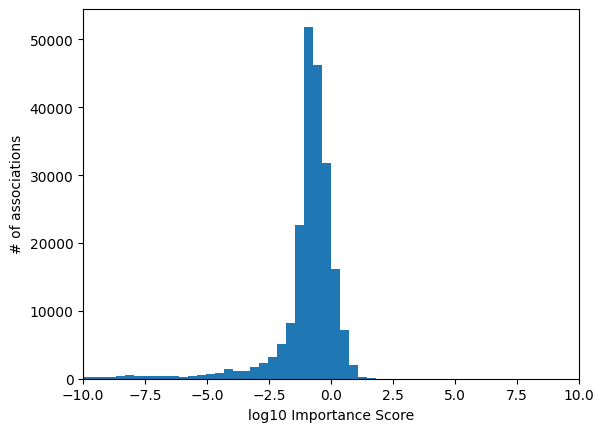

In [92]:
plt.hist(np.log10(results_adjacencies["importance"]), bins=50)
plt.xlabel("log10 Importance Score")
plt.ylabel("# of associations")
plt.xlim([-10, 10])

In [96]:
if not os.path.exists(reg_path):
    !pyscenic ctx {outpath_adj} \
        {db_names} \
        --annotations_fname {motif_path} \
        --expression_mtx_fname {loom_path} \
        --output {reg_path} \
        --mask_dropouts \
        --num_workers {num_workers} > pyscenic_ctx_stdout.txt

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

2025-03-10 18:16:27,309 - pyscenic.cli.pyscenic - INFO - Creating modules.

2025-03-10 18:16:27,368 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-03-10 18:16:27,600 - pyscenic.utils - INFO - Calculating Pearson correlations.

2025-03-10 18:16:27,623 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2025-03-10 18:16:28,363 

In [139]:
results_regulons = pd.read_csv("../data/scenic/reg.csv", index_col=False, sep=",")
results_regulons.head(20)


,Unnamed: 0,Unnamed: 1,Enrichment,Enrichment.1,Enrichment.2,Enrichment.3,Enrichment.4,Enrichment.5,Enrichment.6,Enrichment.7
0,NaN,NaN,AUC,NES,MotifSimilarityQvalue,OrthologousIdentity,Annotation,Context,TargetGenes,RankAtMax
1,TF,MotifID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arid3a,metacluster_9.29,0.11055831951354339,3.1594228043725283,7.24279e-06,1.0,motif similar to transfac_pro__M02735 ('V$ARID...,"frozenset({'weight>75.0%', 'activating', 'mm10...","[('Arid3a', 1.0), ('Hnrnpa0', 0.61163264139819...",621
3,Arid3a,metacluster_9.21,0.13411338369879,4.0685593597096625,4.82481e-06,1.0,motif similar to transfac_pro__M02735 ('V$ARID...,"frozenset({'weight>75.0%', 'activating', 'mm10...","[('Lmo2', 1.1820535788159992), ('Stat5a', 0.56...",378
4,Arid3a,metacluster_9.25,0.12139917695473251,3.5778389765159555,3.1533e-06,1.0,gene is annotated for similar motif transfac_p...,"frozenset({'weight>75.0%', 'activating', 'mm10...","[('Trim24', 1.8922197722698393), ('Stat5a', 0....",439
5,Arid3a,metacluster_9.22,0.12582150973527426,3.748524327192028,2.88361e-06,1.0,motif similar to transfac_pro__M02735 ('V$ARID...,"frozenset({'weight>75.0%', 'activating', 'mm10...","[('Hnrnpa0', 0.611632641398199), ('Adnp2', 0.9...",798
6,Arid3a,metacluster_9.26,0.13561820526994656,4.126639791536937,9.96896e-07,1.0,gene is annotated for similar motif transfac_p...,"frozenset({'weight>75.0%', 'activating', 'mm10...","[('Stat5a', 0.5626549726242231), ('Adnp2', 0.9...",2450
7,Arid3a,metacluster_9.24,0.11065045144647134,3.16297874917828,5.23182e-07,1.0,gene is annotated for similar motif transfac_p...,"frozenset({'weight>75.0%', 'activating', 'mm10...","[('Stat5a', 0.5626549726242231), ('Arid3a', 1....",997
8,Arid3a,tfdimers__MD00048,0.11577912904612739,3.3609263433651138,3.7566e-08,0.803661,gene is orthologous to ENSG00000116017 in H. s...,"frozenset({'weight>75.0%', 'activating', 'mm10...","[('Stat5a', 0.5626549726242231), ('Arid3a', 1....",1728
9,Atf1,tfdimers__MD00594,0.12178239238589661,4.347841380422709,8.89833e-06,0.911439,motif similar to tfdimers__MD00257 ('M00801_re...,"frozenset({'weight>75.0%', 'activating', 'mm10...","[('Smad2', 0.9191577868697304), ('Hp1bp3', 0.9...",697


In [97]:
n_genes_detected_per_cell = np.sum(adata.X > 0, axis=1)
percentiles = pd.Series(n_genes_detected_per_cell.flatten().A.flatten()).quantile(
    [0.01, 0.05, 0.10, 0.20, 0.50, 1]
)
print(percentiles)

0.01      13.00
0.05      19.35
0.10      27.00
0.20      51.00
0.50     196.00
1.00    1232.00
dtype: float64


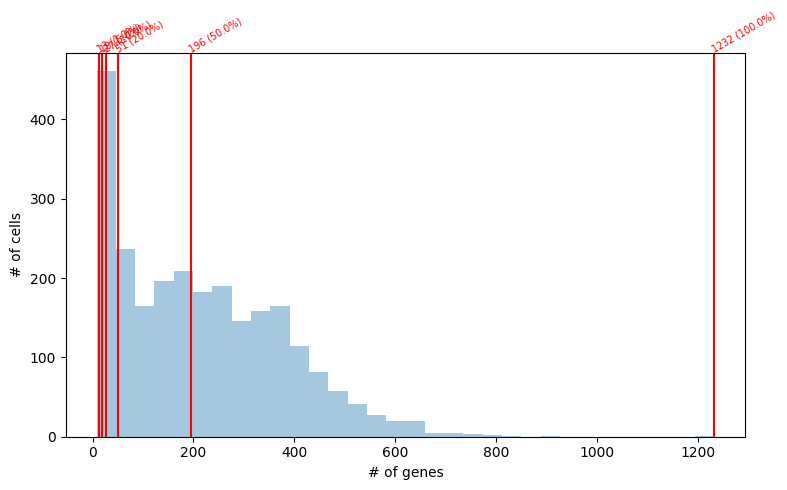

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=100)
sns.distplot(n_genes_detected_per_cell, norm_hist=False, kde=False, bins="fd")
for i, x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0, ymax=1, color="red")
    ax.text(
        x=x,
        y=ax.get_ylim()[1],
        s=f"{int(x)} ({percentiles.index.values[i]*100}%)",
        color="red",
        rotation=30,
        size="x-small",
        rotation_mode="anchor",
    )
ax.set_xlabel("# of genes")
ax.set_ylabel("# of cells")
fig.tight_layout()

In [99]:
if not os.path.exists(loom_path_output):
    !pyscenic aucell $loom_path \
        {reg_path} \
        --output {loom_path_output} \
        --seed 42 \
        --num_workers {num_workers} > pyscenic_aucell_stdout.txt

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

2025-03-10 18:22:28,646 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-03-10 18:22:28,866 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.

2025-03-10 18:22:29,152 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use 

In [100]:
# collect SCENIC AUCell output
lf = lp.connect(loom_path_output, mode="r+", validate=False)
auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [101]:
ad_auc_mtx = ad.AnnData(auc_mtx)
sc.pp.neighbors(ad_auc_mtx, n_neighbors=10, metric="correlation")
sc.tl.umap(ad_auc_mtx)
sc.tl.tsne(ad_auc_mtx)
sc.tl.leiden(ad_auc_mtx, resolution=1)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [102]:
adata.obsm["X_umap_scenic"] = ad_auc_mtx.obsm["X_umap"]
adata.obsm["X_pca_scenic"] = ad_auc_mtx.obsm["X_pca"]
adata.obs["leiden_scenic"] = ad_auc_mtx.obs["leiden"]
adata.obsm["X_tsne_scenic"] = ad_auc_mtx.obsm["X_tsne"]

In [103]:
ad_auc_mtx

AnnData object with n_obs × n_vars = 2488 × 243
    obs: 'leiden'
    uns: 'neighbors', 'umap', 'tsne', 'leiden'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    obsp: 'distances', 'connectivities'

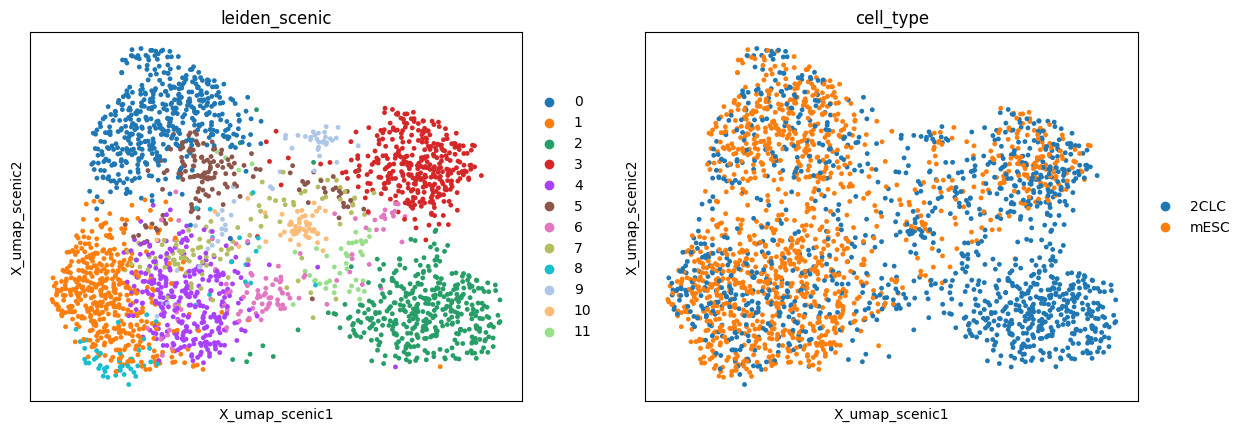

In [104]:
sc.pl.embedding(adata, basis="X_umap_scenic", color=["leiden_scenic", "cell_type"])

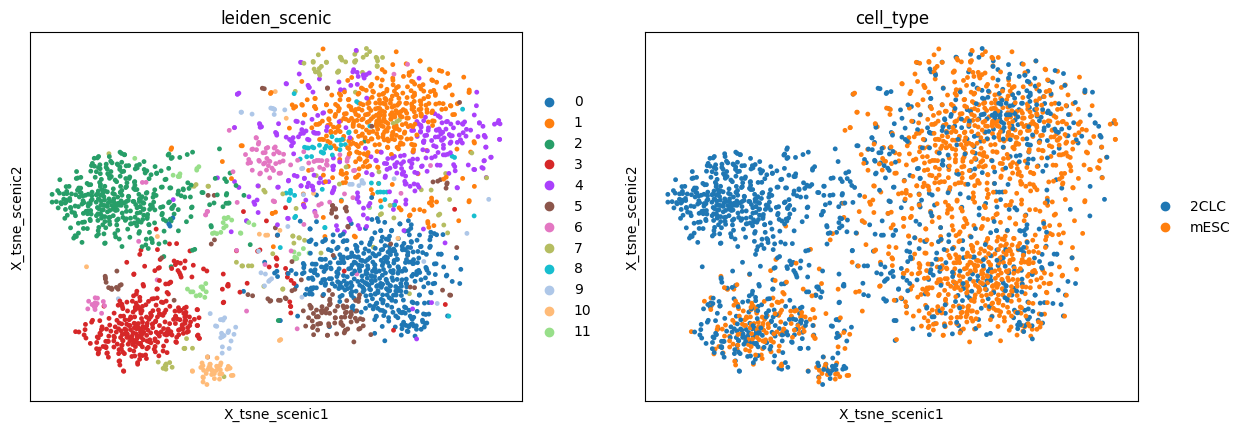

In [105]:
sc.pl.embedding(adata, basis="X_tsne_scenic", color=["leiden_scenic", "cell_type"])

In [114]:
cluster_2clc = adata.obs.groupby("leiden_scenic")["cell_type"].value_counts(normalize=True).unstack().fillna(0)["2CLC"]
adata.uns['2clc_clusters'] = cluster_2clc[cluster_2clc > 0.75].index.to_list()
adata.uns['2clc_clusters']

del cluster_2clc
adata.uns['2clc_clusters']

['2']

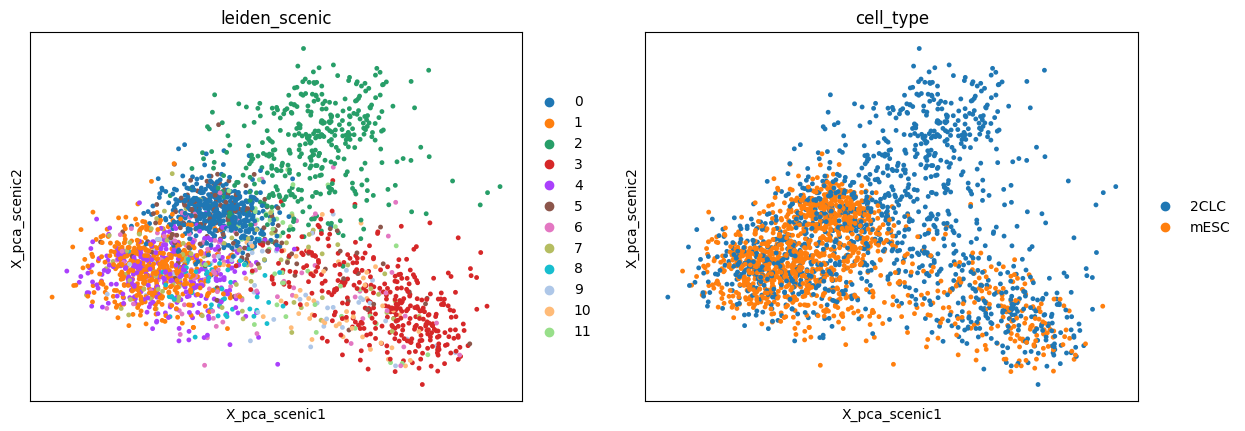

In [106]:
sc.pl.embedding(adata, basis="X_pca_scenic", color=["leiden_scenic", "cell_type"])

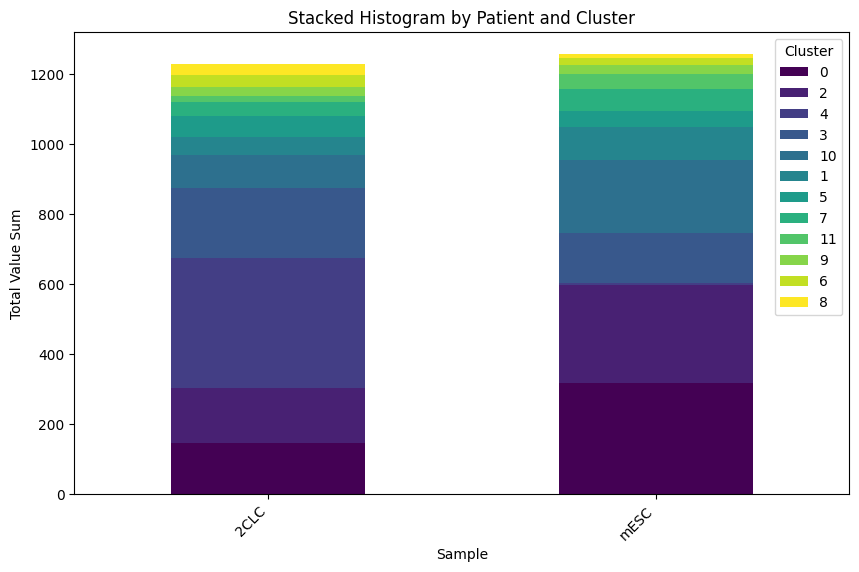

In [110]:
import matplotlib.pyplot as plt

# Raggruppamento dei dati: accediamo alle colonne 'sample' e 'leiden_scenic' che sono dentro adata.obs
adata_grouped = adata.obs.groupby(['cell_type', 'leiden_scenic']).size().unstack(fill_value=0)

# Ordiniamo i pazienti (campioni) per avere sempre lo stesso ordine nei colori
adata_grouped = adata_grouped.sort_index()

# Plot dello stacked bar chart
adata_grouped.plot(kind='bar', stacked=True, cmap="viridis", figsize=(10, 6))

# Etichette e titolo
plt.xlabel("Sample")
plt.ylabel("Total Value Sum")
plt.title("Stacked Histogram by Patient and Cluster")

# Etichette legenda — se i cluster sono numerati è meglio convertirli a stringa
clusters = adata.obs['leiden_scenic'].unique()
plt.legend(title="Cluster", labels=[str(c) for c in clusters])

# Sistemiamo le etichette sull'asse x
plt.xticks(rotation=45, ha="right")

# Mostriamo il plot
plt.show()


In [111]:
auc_mtx["cell_type"] = adata.obs["cell_type"]
mean_auc_by_cell_type = auc_mtx.groupby("cell_type").mean()

In [112]:
top_n = 50
top_tfs = mean_auc_by_cell_type.max(axis=0).sort_values(ascending=False).head(top_n)
mean_auc_by_cell_type_top_n = mean_auc_by_cell_type[
    [c for c in mean_auc_by_cell_type.columns if c in top_tfs]
]

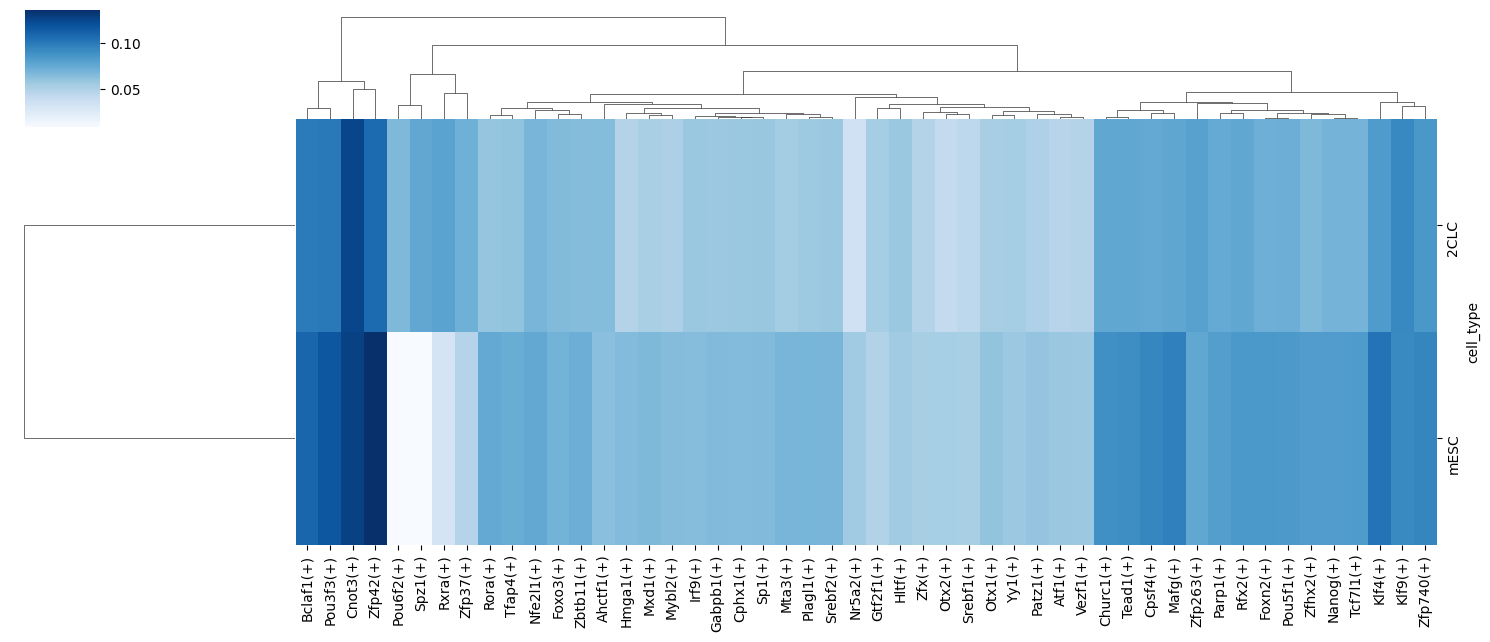

In [113]:
sns.clustermap(
    mean_auc_by_cell_type_top_n,
    figsize=[15, 6.5],
    cmap="Blues",
    xticklabels=True,
    yticklabels=True,
)